# Load_Data

In [68]:
#import 
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
import matplotlib.pyplot as plt

import imutils
import cv2
import argparse
import time
import math

In [35]:
train_dir = './train_images'    # folder containing training images
test_dir = './test_images'    # folder containing test images

transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
    transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
    transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test) 
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32    

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('noface','face')  # indicates that "1" means "face" and "0" non-face (only used for display)

# Network

In [3]:
# Define a convolution neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
net = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.005, weight_decay=0.0001)

In [5]:
# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(net.state_dict(), path)

In [6]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    net.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

In [7]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = net(images)
            
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [8]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = net(images)
    
    #print(outputs)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [36]:
# Let's build our model
train(10)
print('Finished Training')

The model will be running on cpu device
[1,  1000] loss: 0.012
[1,  2000] loss: 0.013
For epoch 1 the test accuracy over the whole test set is 93 %
[2,  1000] loss: 0.013
[2,  2000] loss: 0.013
For epoch 2 the test accuracy over the whole test set is 93 %
[3,  1000] loss: 0.013
[3,  2000] loss: 0.013
For epoch 3 the test accuracy over the whole test set is 93 %
[4,  1000] loss: 0.009
[4,  2000] loss: 0.013
For epoch 4 the test accuracy over the whole test set is 94 %
[5,  1000] loss: 0.012
[5,  2000] loss: 0.010
For epoch 5 the test accuracy over the whole test set is 94 %
[6,  1000] loss: 0.010
[6,  2000] loss: 0.013
For epoch 6 the test accuracy over the whole test set is 94 %
[7,  1000] loss: 0.012
[7,  2000] loss: 0.014
For epoch 7 the test accuracy over the whole test set is 94 %
[8,  1000] loss: 0.011
[8,  2000] loss: 0.011
For epoch 8 the test accuracy over the whole test set is 93 %
[9,  1000] loss: 0.010
[9,  2000] loss: 0.012
For epoch 9 the test accuracy over the whole test 

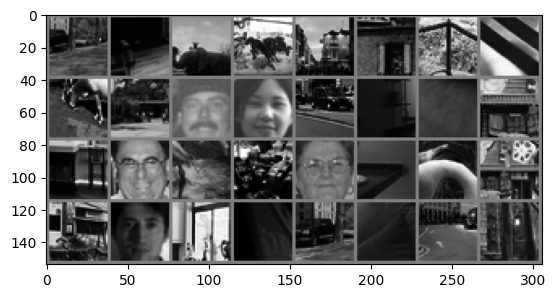

Real labels:  noface noface noface noface noface noface noface noface noface noface  face  face noface noface noface noface noface  face noface noface  face noface noface noface noface  face noface noface noface noface noface noface
Predicted:  noface noface noface noface noface noface noface noface noface noface noface noface noface noface noface noface noface  face noface noface  face noface noface noface noface  face noface noface noface noface noface noface


In [11]:
# Test which classes performed well
testAccuracy()
    
# Let's load the model we just created and test the accuracy per label
model = Net()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch()

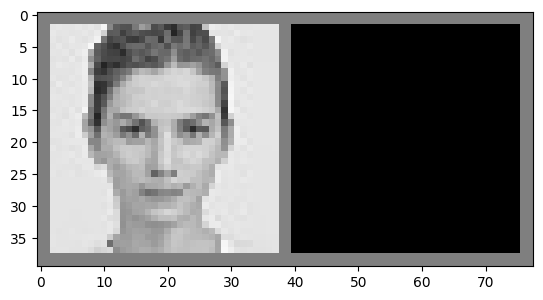

Real labels:   face noface
Predicted:  noface noface


In [12]:
image_dir = './36_images' 

transform = transforms.Compose(
       [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
        transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
        transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test) 
sample_data = torchvision.datasets.ImageFolder(image_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 2    

test_loader = torch.utils.data.DataLoader(sample_data, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('noface', 'face')  # indicates that "1" means "face" and "0" non-face (only used for display)

# Test which classes performed well
testAccuracy()
    
# Let's load the model we just created and test the accuracy per label
model = Net()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))

# Test with batch of images
testBatch()

# Implementing Detector

In [37]:
image_dir = './sample_image'

transform = transforms.Compose(
       [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
        transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
        transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test) 
sample_data = torchvision.datasets.ImageFolder(image_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 2    

test_loader = torch.utils.data.DataLoader(sample_data, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('noface', 'face')  # indicates that "1" means "face" and "0" non-face (only used for display)

In [38]:
images, labels = next(iter(test_loader))

if labels[0] == 1:    # labels = tensor([1, 0])
    images = images[0]
else:                 # labels = tensor([0, 1])
    images = images[1]
    
stepSize = 4
batch_size = 1
(w_width, w_height) = (36, 36)
(width, height) = (150, 150)

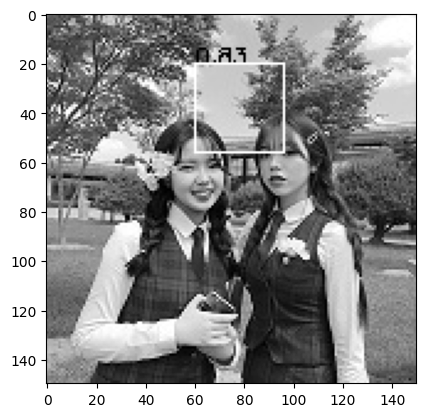

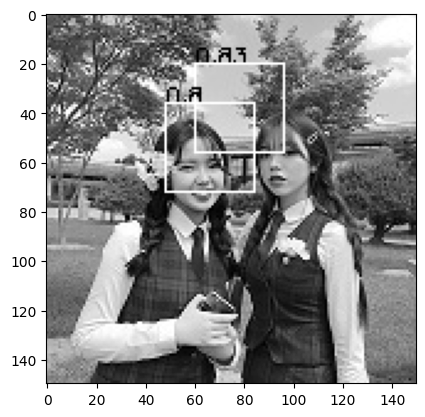

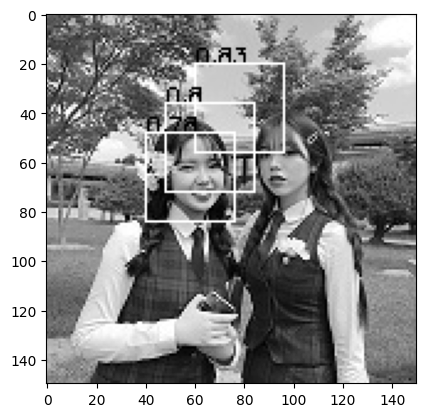

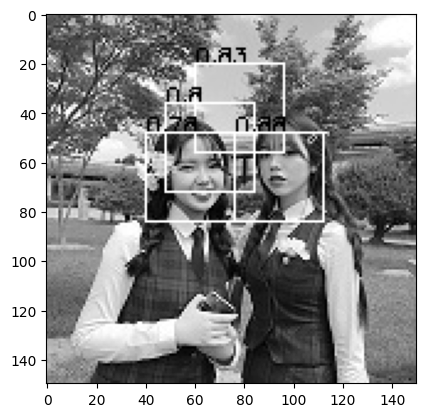

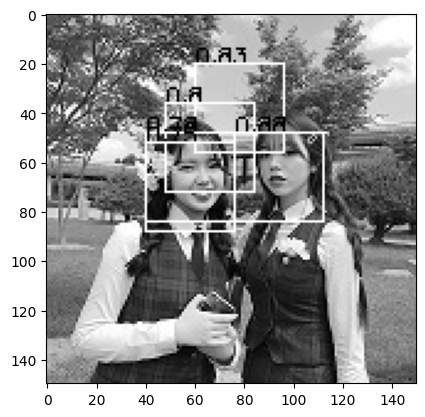

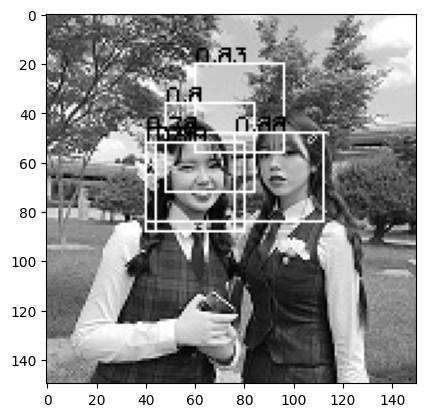

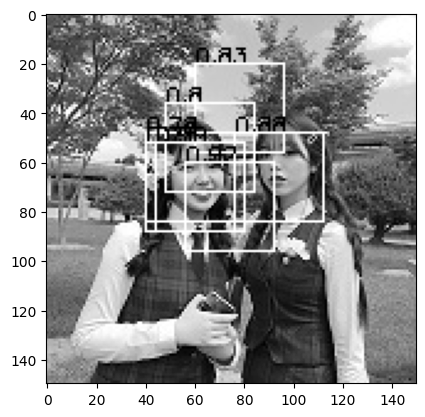

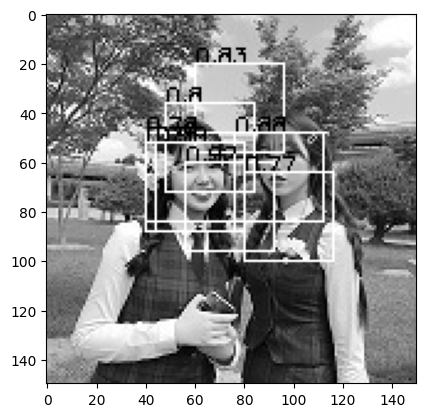

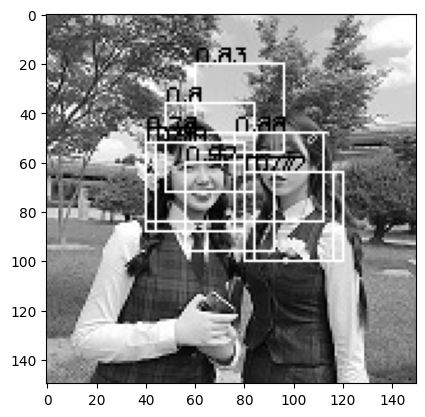

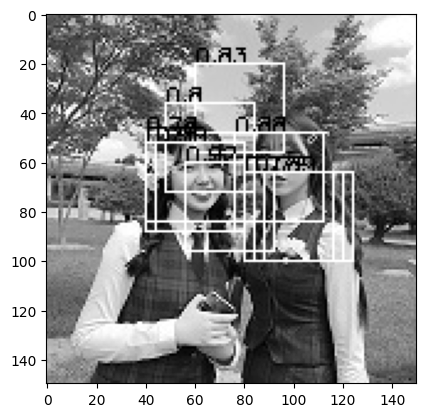

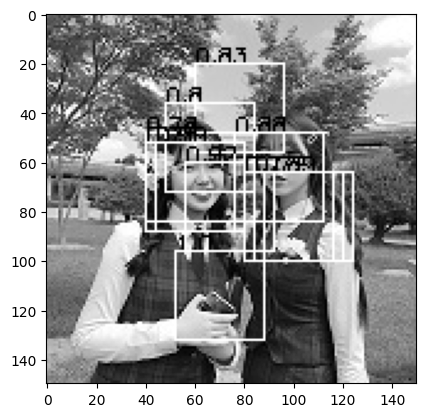

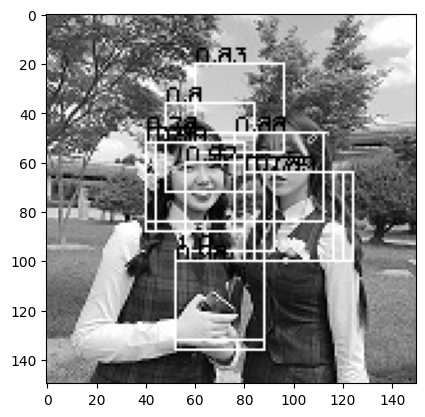

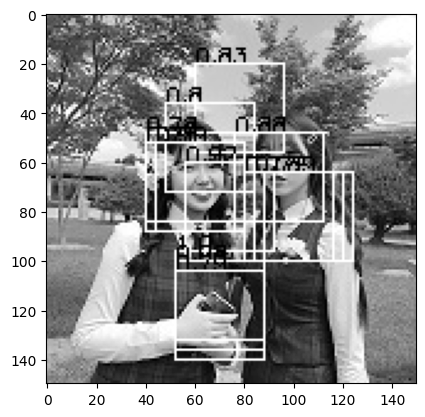

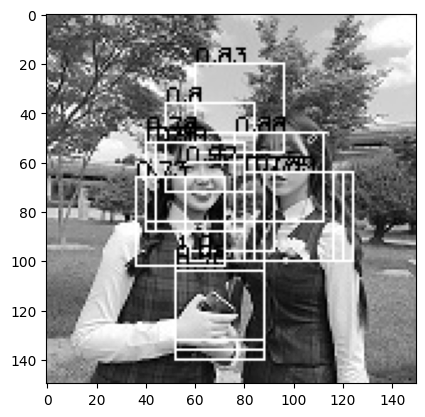

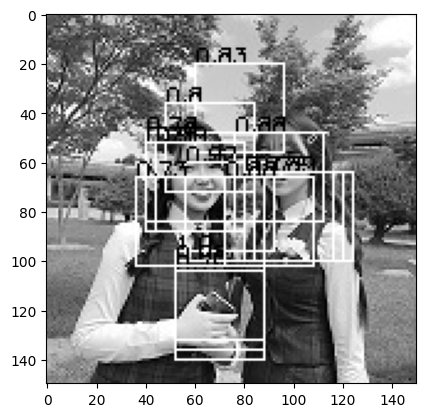

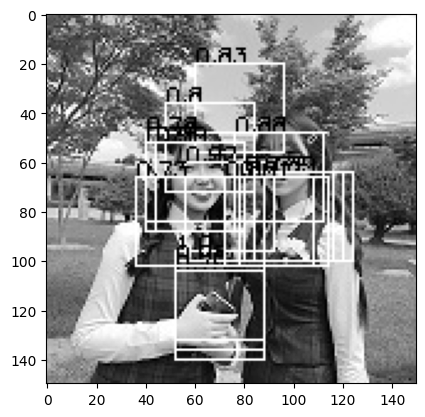

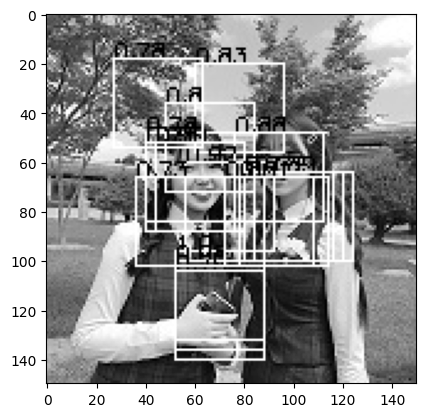

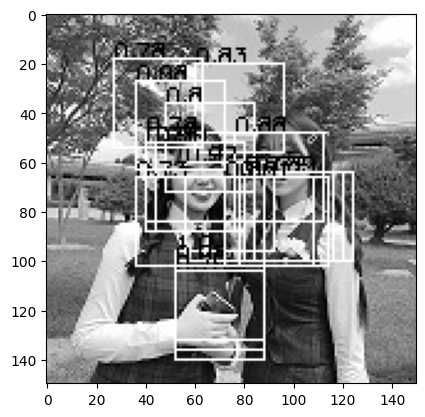

In [91]:
image = cv2.imread('./sample_image/1/testimage.jpg', cv2.IMREAD_GRAYSCALE)

tmp = image
tmp_2 = image

list_x = []
list_y = []
list_softmax = []
str_softmax = []

scale = 1.5
minSize = (36, 36)

convert_tensor = transforms.ToTensor()

#Scaling
cnt = 0
while True:
    if cnt == 0:
        w = int(image.shape[1])
    else:
        w = int(image.shape[1] / scale)
        
    image = imutils.resize(image, width=w)
    
    if image.shape[0] <= minSize[1] or image.shape[1] <= minSize[0]:
        break
    
    image_tensor = convert_tensor(image)
    
    #Sliding Window
    for y in range(0, image.shape[0]-36, stepSize): #세로
        for x in range(0, image.shape[1]-36, stepSize): #가로
            crop_image = transforms.functional.crop(image_tensor, y, x, 36, 36)

            outputs = net(crop_image)

            softmax_outputs = F.softmax(outputs, dim=1)

            if softmax_outputs[0][1] > 0.7:
                list_softmax.append(softmax_outputs[0][1])
                str_softmax.append(str(round(softmax_outputs[0][1].item(),2)))
                list_x.append(int(x*math.pow(1.5, cnt)))
                list_y.append(int(y*math.pow(1.5, cnt)))

            # We got the probability for every 10 labels. The highest (max) probability should be correct label
            _, predicted = torch.max(outputs, 1)
            
    cnt += 1
for i in range(len(list_x)):
    window = tmp[list_y[i]:list_y[i] + w_height, list_x[i]:list_x[i] + w_width]
    cv2.putText(tmp, str_softmax[i], (list_x[i], list_y[i]), cv2.FONT_ITALIC, 0.3 ,(0,255,0), 0)
    cv2.rectangle(tmp, (list_x[i], list_y[i]), (list_x[i] + w_width, list_y[i] + w_height), (255, 0, 0), 1) # draw rectangle on image
    plt.imshow(np.array(tmp).astype('uint8'), cmap="gray")
    plt.show()
    


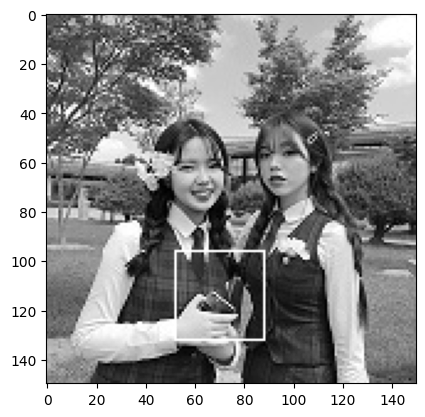

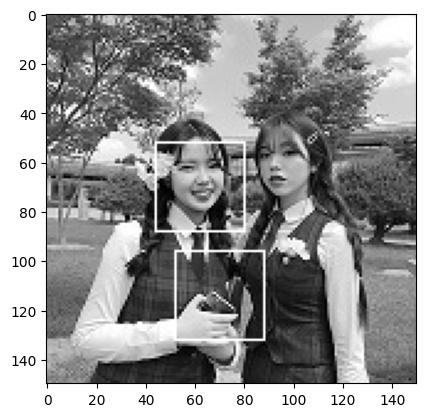

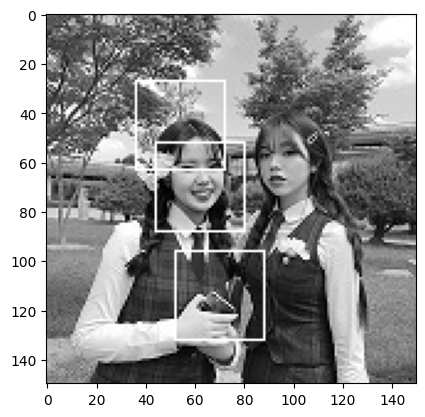

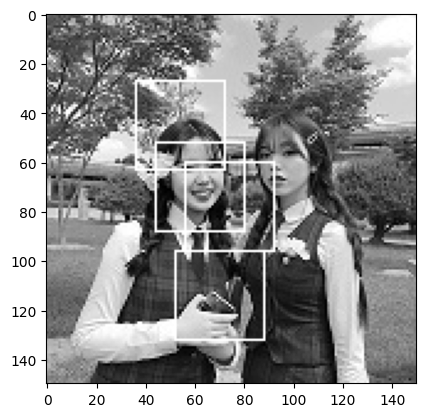

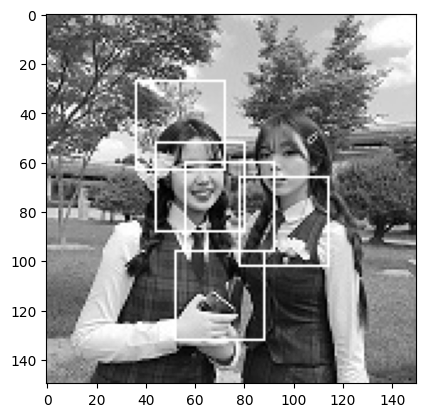

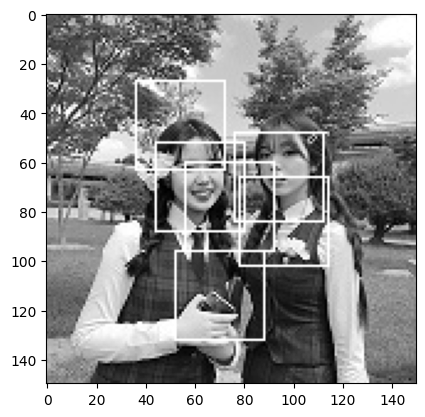

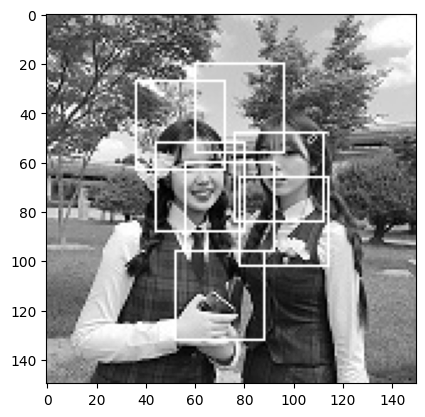

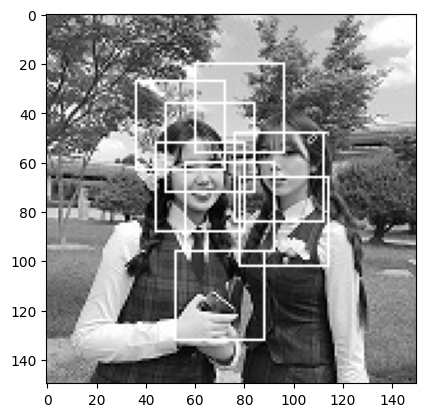

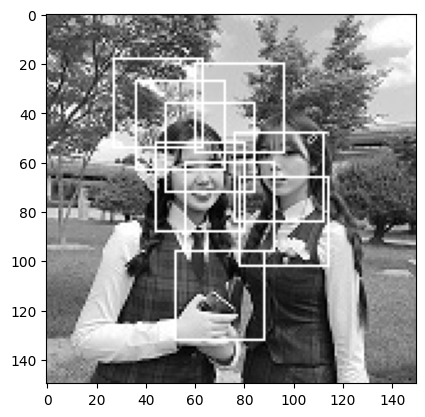

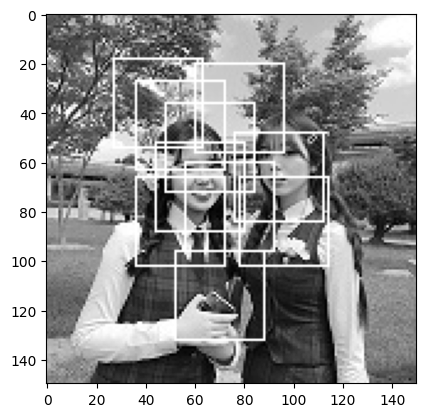

In [77]:
temp_list_total = []
temp_list_part = []
for i in range(len(list_x)):
    temp_list_part = [list_y[i], list_x[i], list_y[i]+36, list_x[i]+36]
    temp_list_total.append(temp_list_part)
    
boxes = torch.tensor(temp_list_total).float()

tensor_softmax = torch.tensor(list_softmax)

final_nms = []
nms_output = torchvision.ops.nms(boxes, tensor_softmax, iou_threshold=0.5)
for i in range(len(nms_output)):
    final_nms.append(boxes[nms_output[i]].int().tolist())
    
img = cv2.imread('./sample_image/1/testimage.jpg', cv2.IMREAD_GRAYSCALE)
    
#cv2.putText(image.jpg, "Text" , (10,10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

for i in range(len(final_nms)):
    window2 = img[final_nms[i][0]:final_nms[i][2], final_nms[i][1]:final_nms[i][3]]
    cv2.rectangle(img, (final_nms[i][1], final_nms[i][0]), (final_nms[i][3], final_nms[i][2]), (255, 0, 0), 1)
    plt.imshow(np.array(img).astype('uint8'), cmap='gray')
    plt.show()